In [ ]:
import pandas as pd
import yfinance as yf

# Stock from the top 50 companies in the SNP 500

stockList= [
    "NVDA", "MSFT", "AAPL", "AMZN", "META",
    "AVGO", "GOOGL", "TSLA",
    "JPM", "WMT", "V", "LLY", "ORCL",
    "MA", "NFLX", "XOM", "JNJ", "COST",
    "HD", "BAC", "PLTR", "ABBV", "PG",
    "CVX", "KO", "GE", "TMUS", "UNH",
    "CSCO", "AMD", "WFC", "PM", "CRM",
    "MS", "ABT", "AXP", "IBM", "GS",
    "LIN", "MCD", "DIS", "RTX", "MRK",
    "T", "PEP", "CAT", "UBER", "NOW",
    "VZ", "INTU"
]
stockList = sorted(stockList)

data = yf.download(stockList, start="2021-01-01", end="2024-01-01", auto_adjust=True)["Close"]
# Using 3 years of data to find suitable pairs
data.head()

[*********************100%***********************]  50 of 50 completed


Ticker,AAPL,ABBV,ABT,AMD,AMZN,AVGO,AXP,BAC,CAT,COST,...,T,TMUS,TSLA,UBER,UNH,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,126.096596,87.365036,100.130585,92.300003,159.331497,38.391968,111.249786,26.900753,166.105804,360.197357,...,16.057774,129.028427,243.256668,51.139999,326.359314,210.421066,44.364792,26.608824,45.727535,34.215038
2021-01-05,127.655609,88.268448,101.369499,92.769997,160.925507,38.651997,111.843544,27.106787,167.464569,356.018799,...,15.959594,128.463333,245.036667,54.009998,321.970520,207.280594,44.161240,27.352432,45.484131,35.863956
2021-01-06,123.358543,87.505913,101.158432,90.330002,156.919006,38.413639,115.981026,28.799845,176.784393,350.598999,...,16.270494,128.151520,251.993332,52.480000,335.482422,205.454285,44.696491,29.287619,45.768108,36.779106
2021-01-07,127.567932,88.442467,102.140366,95.160004,158.108002,40.032482,115.063606,29.435862,177.121826,348.609314,...,16.314135,129.768906,272.013336,56.130001,340.861084,206.604172,44.595901,29.950602,45.764984,37.067669
2021-01-08,128.669006,88.906609,102.424873,94.580002,159.134995,40.235626,115.177101,29.140244,177.149185,350.523254,...,16.201628,131.590881,293.339996,53.279999,339.329651,208.188919,44.039688,29.735579,45.758747,37.479900


<Axes: xlabel='Ticker', ylabel='Ticker'>

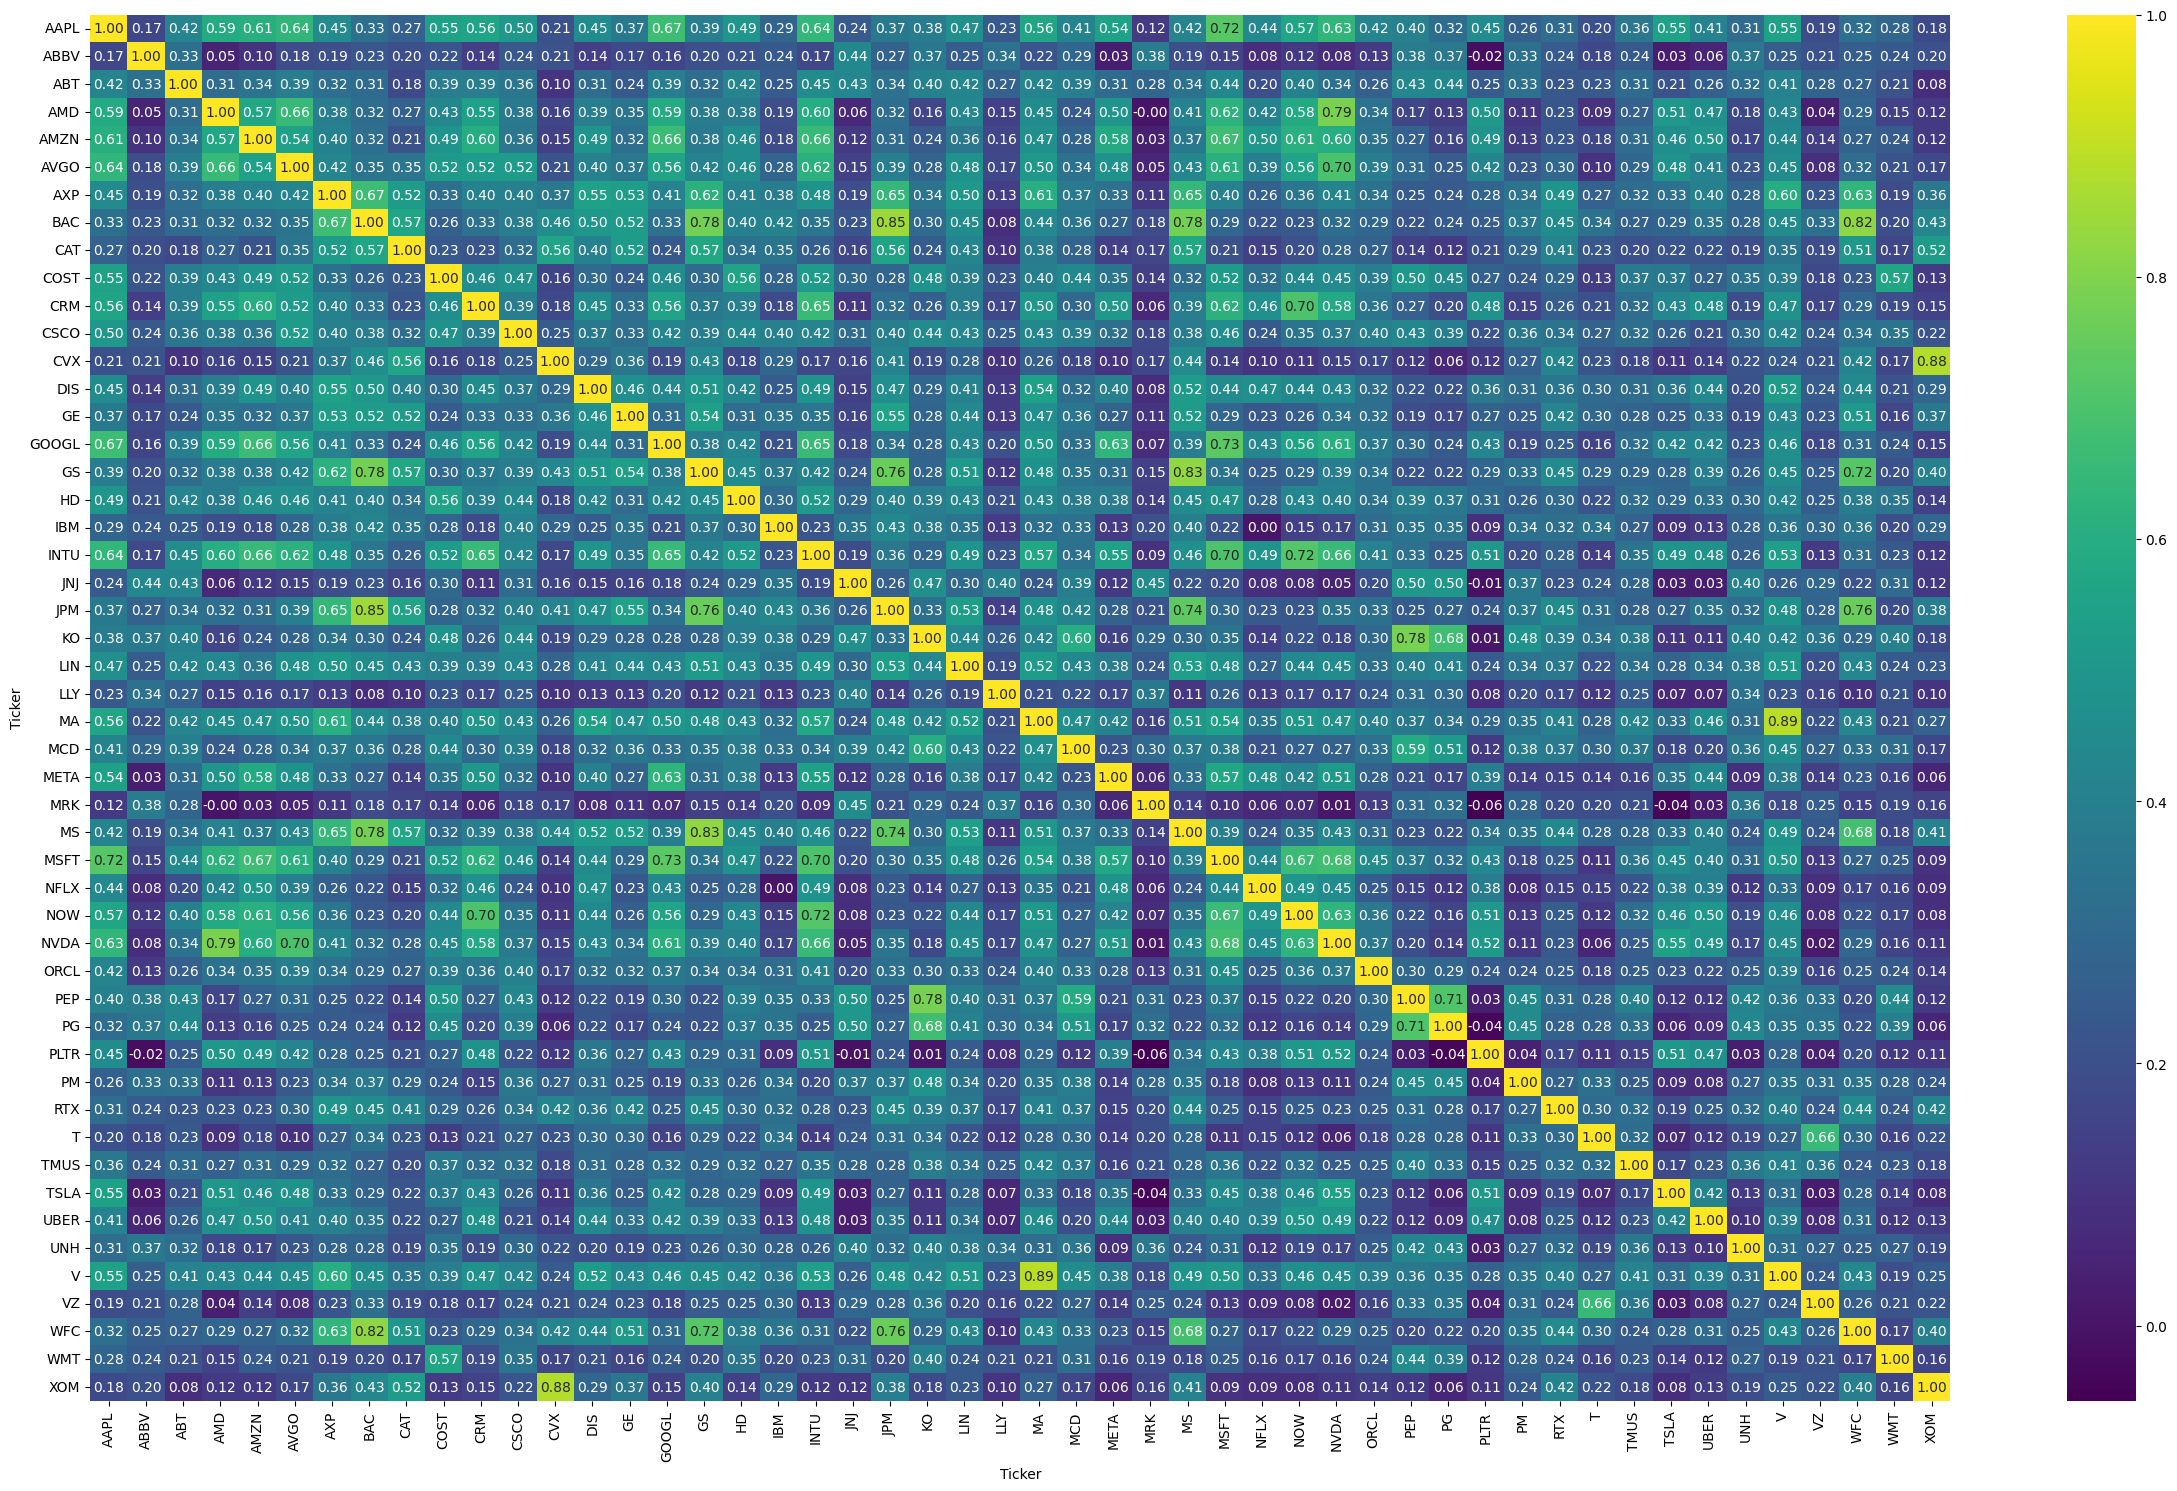

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

log_data = np.log(data)

log_returns = log_data.shift(-1) - log_data
log_returns = log_returns.iloc[:-1]
corr_matrix = log_returns.corr()

plt.figure(figsize=(30, 18))
sns.heatmap(corr_matrix, cmap="viridis", fmt=".2f", annot=True)

In [114]:
# Going to extract pairs correlation >=0.75
# Looser bound as we don't have many pair choices and want to diversify
pairs = list()
for i, stock_row in enumerate(stockList):
    for j, stock_col in enumerate(stockList):
        if i > j and corr_matrix.iloc[i,j] > 0.75: #        Using a lower threshold as log returns tends to be very strict
            pairs.append((stock_row, stock_col))
pairs

[('GS', 'BAC'),
 ('JPM', 'BAC'),
 ('JPM', 'GS'),
 ('MS', 'BAC'),
 ('MS', 'GS'),
 ('NVDA', 'AMD'),
 ('PEP', 'KO'),
 ('V', 'MA'),
 ('WFC', 'BAC'),
 ('WFC', 'JPM'),
 ('XOM', 'CVX')]

In [ ]:
# We'll be using the Augmented Dicky Fuller Test to test for cointegration between pairs
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def regression(stock1,stock2):
    X = log_data[stock1].values
    Y = log_data[stock2].values

    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    b_0, b_1 = model.params

    residuals = Y - (b_0 + b_1 * X[:, 1])

    adf_result = adfuller(residuals)

    return adf_result[0], adf_result[1], b_1, b_0

n = len(pairs)
adf_data = np.empty((n, 4), dtype=float)
# Making a numpy array to put into the data frame soon
for i, pair in enumerate(pairs):
    adf_data[i, :] = regression(*pair)

columns = ("ADF Statistic", "p_val", "B_1", "B_0")
adf_df = pd.DataFrame(data=adf_data, index = pairs, columns=columns)
adf_df
adf_screened = adf_df[adf_df.p_val < 0.05]
adf_screened

,ADF Statistic,p_val,B_1,B_0
"(JPM, GS)",-3.338855,0.013229,0.554108,3.061739
"(PEP, KO)",-3.122363,0.024942,0.737739,0.274064
"(V, MA)",-3.399311,0.010982,0.951951,0.754245


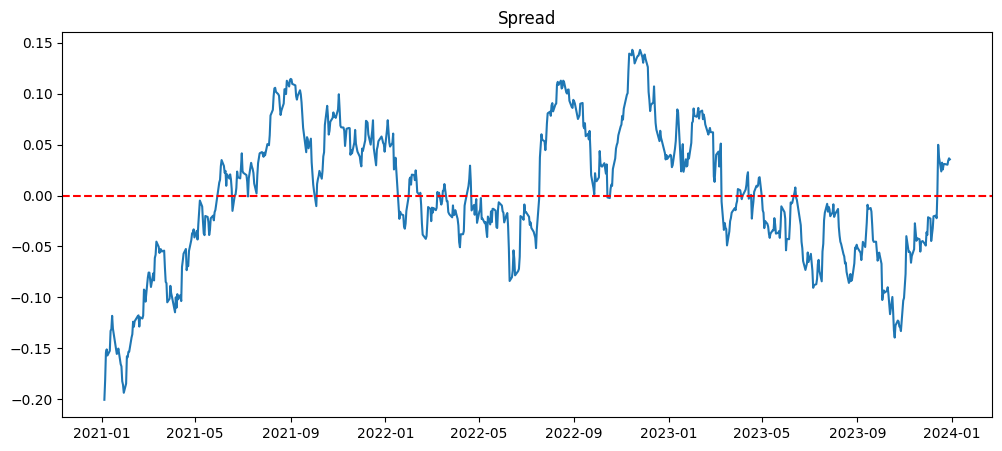

In [ ]:
JG_B0 = adf_screened.iloc[0, 3]
JG_B1 = adf_screened.iloc[0, 2]
JG_spread = log_data["GS"] - (JG_B0 + JG_B1 * log_data["JPM"])
plt.figure(figsize=(12,5))
plt.plot(JG_spread, label = "Spread")
plt.axhline(JG_spread.mean(), color="red", linestyle='--', label = "Mean")
plt.legend
plt.title("Spread")
plt.show()

# -----------------------------------
# QUICK PLOT TO SEE SPREAD VARIATION
# -----------------------------------

# Spread seems to be centred around 0 for our pair (JPM,GS)
# Let's do the same for our other pairs

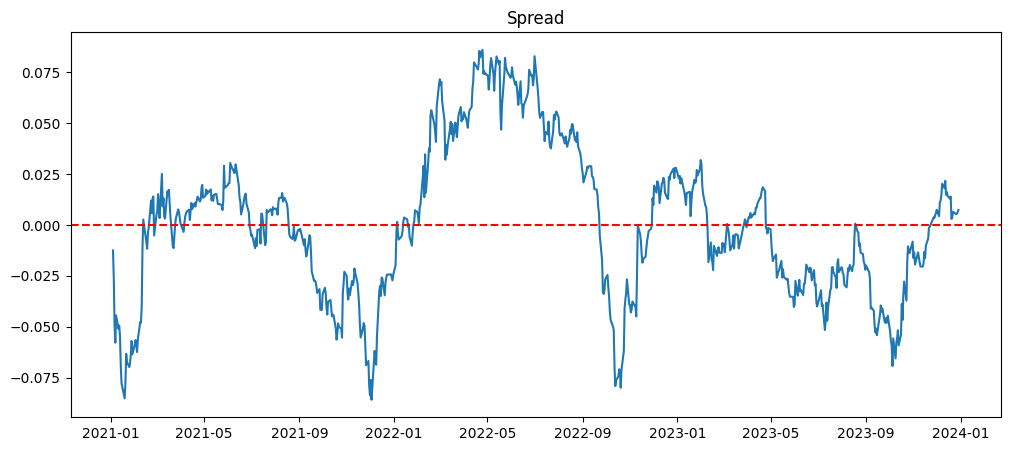

In [ ]:
# -----------------------------
# ANOTHER QUICK SANITY PLOT (PEP, KO)
# -----------------------------

PK_B0 = adf_screened.iloc[1, 3]
PK_B1 = adf_screened.iloc[1, 2]
PK_spread = log_data["KO"] - (PK_B0 + PK_B1 * log_data["PEP"])
plt.figure(figsize=(12,5))
plt.plot(PK_spread, label = "Spread")
plt.axhline(PK_spread.mean(), color="red", linestyle='--', label = "Mean")
plt.legend
plt.title("Spread")
plt.show()

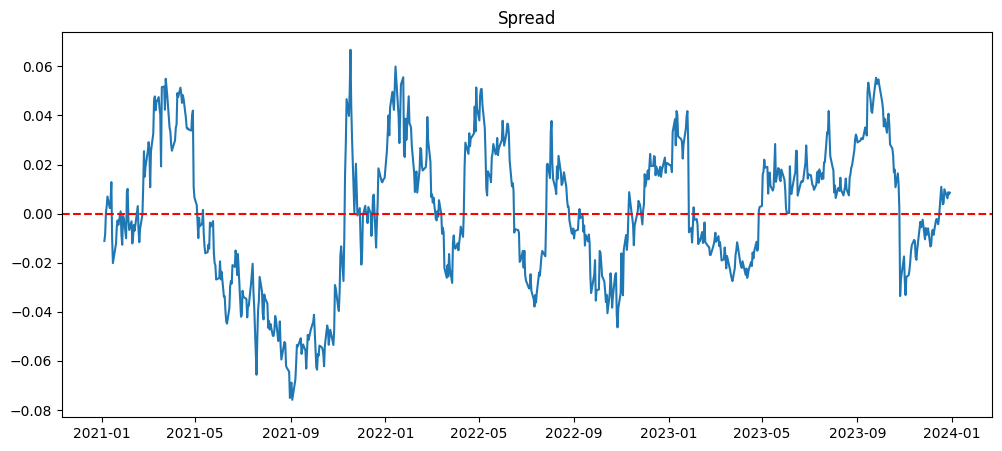

In [ ]:
# -----------------------------
# ANOTHER QUICK SANITY PLOT (V, MA)
# -----------------------------

VM_B0 = adf_screened.iloc[2, 3]
VM_B1 = adf_screened.iloc[2, 2]
VM_spread = log_data["MA"] - (VM_B0 + VM_B1 * log_data["V"])
plt.figure(figsize=(12,5))
plt.plot(VM_spread, label = "Spread")
plt.axhline(VM_spread.mean(), color="red", linestyle='--', label = "Mean")
plt.legend
plt.title("Spread")
plt.show()

# We can see that our spread moves between 0 for all pairs